In [2]:
import sys
!{sys.executable} -m pip install pgmpy
!{sys.executable} -m pip install --upgrade pip

     |████████████████████████████████| 1.9 MB 9.4 MB/s 
     |████████████████████████████████| 1.7 MB 10.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.factors.discrete import State
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#network definition
nba = BayesianModel([('NumAllStars', 'NetRtg'), ('TrueShooting', 'NetRtg'), 
                     ('Conference', 'Playoffs'), ('NetRtg', 'Win'),('StrenghtOfSchedule','Win'), ('Win', 'Playoffs')])

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  FutureWarning,


In [5]:
# defining cpds
# a = [[a=0b=0,a=0b=1],[a=1b=0,a=1b=1]...] ev=b
# a = [[a=0b=0c=0,a=0b=0c=1,a=0b=1c=0],[a=1b=0c=0,a=1b=0c=1]...] ev=b3,c2

# 0 = east, 1 = west
conf_cpd=TabularCPD('Conference',2,[[.5],[.5]])
# 0,1,2,3
nas_cpd=TabularCPD('NumAllStars',4,[[.4],[.35],[.18],[.07]])
# 0 = -56, 1 = 56+
ts_cpd=TabularCPD('TrueShooting',2,[[.39],[.61]])
# 0 = above average, 1 = equal or below average
sos_cpd=TabularCPD('StrenghtOfSchedule',2,[[.5],[.5]])
# 0 = negative, 1 = neutral or positive
# 0 as - ts | 0 as + ts | 1 as - ts | 1 as + ts | 2 as -ts | 2 as + ts | 3 as - ts | 3 as + ts
net_cpd=TabularCPD('NetRtg',2,[[.92,.05,.39,.28,.03,.01,.01,.01],
                               [.08,.95,.61,.72,.97,.99,.99,.99]],evidence=['NumAllStars', 'TrueShooting'],evidence_card=[4,2])
# 0 = below .500, 1 = .500 or more
win_cpd=TabularCPD('Win',2,[[.98,.68,.06,.01],[.02,.32,.94,.99]],evidence=['NetRtg', 'StrenghtOfSchedule'],evidence_card=[2,2])

# 0 = out, 1 = playin (7-8-9-10), 2 = playoffs (1-6)
po_cpd=TabularCPD('Playoffs',3,[[.70,.03,.78,.1],[.24,.14,.20,.35],[.06,.83,.02,.55]],evidence=['Conference', 'Win'],evidence_card=[2,2])

In [6]:
nba.add_cpds(conf_cpd, nas_cpd, ts_cpd, sos_cpd, net_cpd, win_cpd, po_cpd)
nba.check_model()

True

In [7]:
print(nas_cpd)

+----------------+------+
| NumAllStars(0) | 0.4  |
+----------------+------+
| NumAllStars(1) | 0.35 |
+----------------+------+
| NumAllStars(2) | 0.18 |
+----------------+------+
| NumAllStars(3) | 0.07 |
+----------------+------+


In [8]:
print(ts_cpd)

+-----------------+------+
| TrueShooting(0) | 0.39 |
+-----------------+------+
| TrueShooting(1) | 0.61 |
+-----------------+------+


In [9]:
print(net_cpd)

+--------------+-----------------+-----+-----------------+
| NumAllStars  | NumAllStars(0)  | ... | NumAllStars(3)  |
+--------------+-----------------+-----+-----------------+
| TrueShooting | TrueShooting(0) | ... | TrueShooting(1) |
+--------------+-----------------+-----+-----------------+
| NetRtg(0)    | 0.92            | ... | 0.01            |
+--------------+-----------------+-----+-----------------+
| NetRtg(1)    | 0.08            | ... | 0.99            |
+--------------+-----------------+-----+-----------------+


In [10]:
print(win_cpd)

+--------------------+-----+-----------------------+
| NetRtg             | ... | NetRtg(1)             |
+--------------------+-----+-----------------------+
| StrenghtOfSchedule | ... | StrenghtOfSchedule(1) |
+--------------------+-----+-----------------------+
| Win(0)             | ... | 0.01                  |
+--------------------+-----+-----------------------+
| Win(1)             | ... | 0.99                  |
+--------------------+-----+-----------------------+


In [11]:
print(po_cpd)

+-------------+---------------+---------------+---------------+---------------+
| Conference  | Conference(0) | Conference(0) | Conference(1) | Conference(1) |
+-------------+---------------+---------------+---------------+---------------+
| Win         | Win(0)        | Win(1)        | Win(0)        | Win(1)        |
+-------------+---------------+---------------+---------------+---------------+
| Playoffs(0) | 0.7           | 0.03          | 0.78          | 0.1           |
+-------------+---------------+---------------+---------------+---------------+
| Playoffs(1) | 0.24          | 0.14          | 0.2           | 0.35          |
+-------------+---------------+---------------+---------------+---------------+
| Playoffs(2) | 0.06          | 0.83          | 0.02          | 0.55          |
+-------------+---------------+---------------+---------------+---------------+


In [12]:
nba_inference = VariableElimination(nba)
print('\n P(Playoffs)')
q_1 = nba_inference.query(['Playoffs'])
print(q_1)


 P(Playoffs)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

+-------------+-----------------+
| Playoffs    |   phi(Playoffs) |
+=============+=================+
| Playoffs(0) |          0.2349 |
+-------------+-----------------+
| Playoffs(1) |          0.2387 |
+-------------+-----------------+
| Playoffs(2) |          0.5264 |
+-------------+-----------------+


In [13]:
print('\n P(Playoffs|Conference=West)')
q_2 = nba_inference.query(['Playoffs'],{'Conference':1})
print(q_2)


 P(Playoffs|Conference=West)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+-------------+-----------------+
| Playoffs    |   phi(Playoffs) |
+=============+=================+
| Playoffs(0) |          0.2712 |
+-------------+-----------------+
| Playoffs(1) |          0.3122 |
+-------------+-----------------+
| Playoffs(2) |          0.4166 |
+-------------+-----------------+


In [14]:
print('\n P(Playoffs|Conference=East)')
q_bb = nba_inference.query(['Playoffs'],{'Conference':0})
print(q_bb)


 P(Playoffs|Conference=East)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+-------------+-----------------+
| Playoffs    |   phi(Playoffs) |
+=============+=================+
| Playoffs(0) |          0.1987 |
+-------------+-----------------+
| Playoffs(1) |          0.1652 |
+-------------+-----------------+
| Playoffs(2) |          0.6362 |
+-------------+-----------------+


In [15]:
print('\n P(Playoffs|Conference=West,Win=below .500)')
q_3 = nba_inference.query(['Playoffs'],{'Conference':1,'Win':0})
print(q_3)


 P(Playoffs|Conference=West,Win=below .500)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-------------+-----------------+
| Playoffs    |   phi(Playoffs) |
+=============+=================+
| Playoffs(0) |          0.7800 |
+-------------+-----------------+
| Playoffs(1) |          0.2000 |
+-------------+-----------------+
| Playoffs(2) |          0.0200 |
+-------------+-----------------+


In [16]:
print('\n P(Playoffs|Conference=West,Win=over .500)')
q_4 = nba_inference.query(['Playoffs'],{'Conference':1,'Win':1})
print(q_4)


 P(Playoffs|Conference=West,Win=over .500)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-------------+-----------------+
| Playoffs    |   phi(Playoffs) |
+=============+=================+
| Playoffs(0) |          0.1000 |
+-------------+-----------------+
| Playoffs(1) |          0.3500 |
+-------------+-----------------+
| Playoffs(2) |          0.5500 |
+-------------+-----------------+


In [17]:
print('\n P(Playoffs|Conference=West,All Stars Number = 0)')
q_7 = nba_inference.query(['Playoffs'],{'Conference':1,'NumAllStars':0})
print(q_7)


 P(Playoffs|Conference=West,All Stars Number = 0)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+-------------+-----------------+
| Playoffs    |   phi(Playoffs) |
+=============+=================+
| Playoffs(0) |          0.3343 |
+-------------+-----------------+
| Playoffs(1) |          0.2983 |
+-------------+-----------------+
| Playoffs(2) |          0.3674 |
+-------------+-----------------+


In [18]:
print('\n P(Playoffs|Conference=West,All Stars Number = 1)')
q_6 = nba_inference.query(['Playoffs'],{'Conference':1,'NumAllStars':1})
print(q_6)


 P(Playoffs|Conference=West,All Stars Number = 1)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+-------------+-----------------+
| Playoffs    |   phi(Playoffs) |
+=============+=================+
| Playoffs(0) |          0.2984 |
+-------------+-----------------+
| Playoffs(1) |          0.3062 |
+-------------+-----------------+
| Playoffs(2) |          0.3954 |
+-------------+-----------------+


In [19]:
print('\n P(Playoffs|Conference=West,All Stars Number = 2)')
q_5 = nba_inference.query(['Playoffs'],{'Conference':1,'NumAllStars':2})
print(q_5)


 P(Playoffs|Conference=West,All Stars Number = 2)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+-------------+-----------------+
| Playoffs    |   phi(Playoffs) |
+=============+=================+
| Playoffs(0) |          0.1334 |
+-------------+-----------------+
| Playoffs(1) |          0.3426 |
+-------------+-----------------+
| Playoffs(2) |          0.5239 |
+-------------+-----------------+


In [20]:
print('\n P(Playoffs|Conference=East,All Stars Number = 0)')
q_9 = nba_inference.query(['Playoffs'],{'Conference':0,'NumAllStars':0})
print(q_9)


 P(Playoffs|Conference=East,All Stars Number = 0)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+-------------+-----------------+
| Playoffs    |   phi(Playoffs) |
+=============+=================+
| Playoffs(0) |          0.2608 |
+-------------+-----------------+
| Playoffs(1) |          0.1744 |
+-------------+-----------------+
| Playoffs(2) |          0.5647 |
+-------------+-----------------+


In [21]:
print('\n P(Playoffs|Conference=East,All Stars Number = 1)')
q_10 = nba_inference.query(['Playoffs'],{'Conference':0,'NumAllStars':1})
print(q_10)


 P(Playoffs|Conference=East,All Stars Number = 1)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+-------------+-----------------+
| Playoffs    |   phi(Playoffs) |
+=============+=================+
| Playoffs(0) |          0.2254 |
+-------------+-----------------+
| Playoffs(1) |          0.1692 |
+-------------+-----------------+
| Playoffs(2) |          0.6054 |
+-------------+-----------------+


In [22]:
print('\n P(Playoffs|Conference=East,All Stars Number = 2)')
q_11 = nba_inference.query(['Playoffs'],{'Conference':0,'NumAllStars':2})
print(q_11)


 P(Playoffs|Conference=East,All Stars Number = 2)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+-------------+-----------------+
| Playoffs    |   phi(Playoffs) |
+=============+=================+
| Playoffs(0) |          0.0629 |
+-------------+-----------------+
| Playoffs(1) |          0.1449 |
+-------------+-----------------+
| Playoffs(2) |          0.7922 |
+-------------+-----------------+


In [23]:
print('\n P(TS|Playoffs=1-6)')
q_12 = nba_inference.query(['TrueShooting'],{'Playoffs':2})
print(q_12)


 P(TS|Playoffs=1-6)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+-----------------+---------------------+
| TrueShooting    |   phi(TrueShooting) |
+=================+=====================+
| TrueShooting(0) |              0.2989 |
+-----------------+---------------------+
| TrueShooting(1) |              0.7011 |
+-----------------+---------------------+


In [24]:
print('\n P(TS|Playoffs=7-10)')
q_13 = nba_inference.query(['TrueShooting'],{'Playoffs':1})
print(q_13)


 P(TS|Playoffs=7-10)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+-----------------+---------------------+
| TrueShooting    |   phi(TrueShooting) |
+=================+=====================+
| TrueShooting(0) |              0.3823 |
+-----------------+---------------------+
| TrueShooting(1) |              0.6177 |
+-----------------+---------------------+


In [25]:
print('\n P(TS|Playoffs=no)')
q_14 = nba_inference.query(['TrueShooting'],{'Playoffs':0})
print(q_14)


 P(TS|Playoffs=no)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+-----------------+---------------------+
| TrueShooting    |   phi(TrueShooting) |
+=================+=====================+
| TrueShooting(0) |              0.6020 |
+-----------------+---------------------+
| TrueShooting(1) |              0.3980 |
+-----------------+---------------------+


In [26]:
print('\n P(Playoffs|Net Rating=below avg)')
q_15 = nba_inference.query(['Playoffs'],{'NetRtg':0})
print(q_15)


 P(Playoffs|Net Rating=below avg)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

+-------------+-----------------+
| Playoffs    |   phi(Playoffs) |
+=============+=================+
| Playoffs(0) |          0.6253 |
+-------------+-----------------+
| Playoffs(1) |          0.2243 |
+-------------+-----------------+
| Playoffs(2) |          0.1505 |
+-------------+-----------------+


In [27]:
print('\n P(Playoffs|Net Rating=below avg,Schedule=hard)')
q_16 = nba_inference.query(['Playoffs'],{'NetRtg':0, 'StrenghtOfSchedule':0})
print(q_16)


 P(Playoffs|Net Rating=below avg,Schedule=hard)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+-------------+-----------------+
| Playoffs    |   phi(Playoffs) |
+=============+=================+
| Playoffs(0) |          0.7265 |
+-------------+-----------------+
| Playoffs(1) |          0.2205 |
+-------------+-----------------+
| Playoffs(2) |          0.0530 |
+-------------+-----------------+


In [28]:
print('\n P(Playoffs|Net Rating=below avg,Schedule=easy)')
q_17 = nba_inference.query(['Playoffs'],{'NetRtg':0, 'StrenghtOfSchedule':1})
print(q_17)


 P(Playoffs|Net Rating=below avg,Schedule=easy)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+-------------+-----------------+
| Playoffs    |   phi(Playoffs) |
+=============+=================+
| Playoffs(0) |          0.5240 |
+-------------+-----------------+
| Playoffs(1) |          0.2280 |
+-------------+-----------------+
| Playoffs(2) |          0.2480 |
+-------------+-----------------+


In [42]:
precision = 3
p1as= nba_inference.query(['Conference'],{'Playoffs':1,'Win':0}).values[1]
print('\nP(Conference= West|Playoffs=playin,Win= under .500) = ', round(p1as,precision))
plowts = nba_inference.query(['TrueShooting'],{'Playoffs':1,'Win':0}).values[1]
print('\nP(Ts=high|Playoffs=playin,Win= under .500) = ', round(plowts,precision))


0it [00:00, ?it/s]

0it [00:00, ?it/s]


P(Conference= West|Playoffs=playin,Win=above.500) =  0.455


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


P(Ts=high|Playoffs=playin,Win=above.500) =  0.317


In [43]:
# Now switch to sampling methods
inference = BayesianModelSampling(nba)
evidence = [State('Playoffs', 1),State('Win', 0)]
verbose = True

def prob_LW(samples,variable):
    return round(np.sum(np.dot(samples[variable],samples['_weight']))/np.sum(samples['_weight']),2)

def relative_error(exact_value,approx_value):
    return np.absolute((exact_value-approx_value)/exact_value)

def absolute_error(exact_value,approx_value):
    return np.absolute(exact_value-approx_value)

def run_experiment(sample_size):
    # Sample
    samples_LW = inference.likelihood_weighted_sample(evidence = evidence, size=sample_size)
    samples_RS = inference.rejection_sample(evidence=evidence, size=sample_size)

    # Statistics
    p1as_LW=prob_LW(samples_LW,'Conference')
    plowts_LW=prob_LW(samples_LW,'TrueShooting')
    p1as_RS=np.recarray.mean(samples_RS['Conference'].to_numpy(), axis=0)
    plowts_RS=np.recarray.mean(samples_RS['TrueShooting'].to_numpy(), axis=0)
    
    # Reporting
    if(verbose):
        print()
        print("\nP(Conference=1|Playoffs=playin,Win=under.500) =", round(p1as,precision))
        print("With Rejection Sampling after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size, p1as_RS, absolute_error(p1as,p1as_RS)*100))
        print("With Likelihood Weighting after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size, p1as_LW, absolute_error(p1as,p1as_LW)*100))
        print()
        print("\nP(Ts=high|Playoffs=playin,Win=under.500) =", round(plowts,precision))
        print("With Rejection Sampling after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size, plowts_RS, absolute_error(plowts,plowts_RS)*100))
        print("With Likelihood Weighting after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size, plowts_LW, absolute_error(plowts,plowts_LW)*100))
    
    # Return results
    return np.array([(sample_size, 
                      p1as_RS, absolute_error(p1as,p1as_RS),
                      p1as_LW, absolute_error(p1as,p1as_LW),
                      plowts_RS, absolute_error(plowts,plowts_RS),
                      plowts_LW, absolute_error(plowts,plowts_LW))], 
                    dtype=[('sample_size', '<i8'), 
                           ('p1as_RS', '<f8'),('e_p1as_RS', '<f8'),
                           ('p1as_LW', '<f8'),('e_p1as_LW', '<f8'),
                           ('plowts_RS', '<f8'),('e_plowts_RS', '<f8'),
                           ('plowts_LW', '<f8'),('e_plowts_LW', '<f8')])

# To view samples
# print(samples_LW)
# samples_LW.view()
# print(samples_RS[:5]), print(' ... '), print(samples_RS[nsamples_RS-5:])

In [ ]:
results = np.array([],dtype=[('sample_size', '<i8'), 
                             ('p1as_RS', '<f8'),('e_p1as_RS', '<f8'),
                             ('p1as_LW', '<f8'),('e_p1as_LW', '<f8'),
                             ('plowts_RS', '<f8'),('e_plowts_RS', '<f8'),
                             ('plowts_LW', '<f8'),('e_plowts_LW', '<f8')])
starting_size_= 1 # from 10 sample points
final_size= 5.2     # to 10^5.2 sample points
experiments= 20 

for size in np.logspace(starting_size_, final_size, num=experiments, dtype='<i8'):
    results=np.append(results,run_experiment(size))
    
print(results)

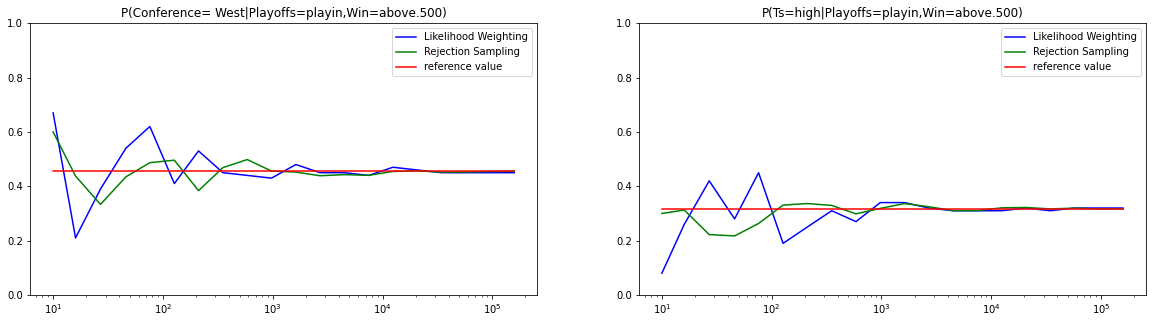

In [52]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.ylim(0,1)
plt.title('P(Conference= West|Playoffs=playin,Win=under.500)')
LWCplot, = plt.semilogx(results['sample_size'],results['p1as_LW'],'b',label="Likelihood Weighting")
RSCplot, = plt.semilogx(results['sample_size'],results['p1as_RS'],'g',label="Rejection Sampling")
VECplot, = plt.semilogx(results['sample_size'],p1as*np.ones(results.size),'r',label="reference value")
plt.legend(handles=[LWCplot,RSCplot,VECplot])
plt.subplot(122)
plt.ylim(0,1)
plt.title('P(Ts=high|Playoffs=playin,Win=under.500)')
LWCplot, = plt.semilogx(results['sample_size'],results['plowts_LW'],'b',label="Likelihood Weighting")
RSCplot, = plt.semilogx(results['sample_size'],results['plowts_RS'],'g',label="Rejection Sampling")
VECplot, = plt.semilogx(results['sample_size'],plowts*np.ones(results.size),'r',label="reference value")
plt.legend(handles=[LWCplot,RSCplot,VECplot])
plt.show()

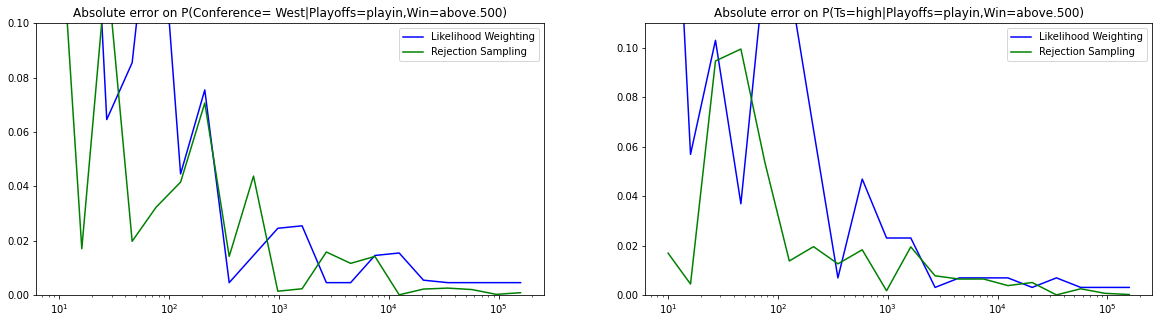

In [53]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.ylim(0,.1)
plt.title('Absolute error on P(Conference= West|Playoffs=playin,Win= under .500)')
ELWCplot, = plt.semilogx(results['sample_size'],results['e_p1as_LW'],'b',label="Likelihood Weighting")
ERSCplot, = plt.semilogx(results['sample_size'],results['e_p1as_RS'],'g',label="Rejection Sampling")
plt.legend(handles=[ELWCplot,ERSCplot])
plt.subplot(122)
plt.ylim(0,.11)
plt.title('Absolute error on P(Ts=high|Playoffs=playin,Win= under .500)')
ELWCplot, = plt.semilogx(results['sample_size'],results['e_plowts_LW'],'b',label="Likelihood Weighting")
ERSCplot, = plt.semilogx(results['sample_size'],results['e_plowts_RS'],'g',label="Rejection Sampling")
plt.legend(handles=[ELWCplot,ERSCplot])
plt.show()

In [54]:
q_yy = nba_inference.query(['Playoffs'],{})
print(q_yy)
q_yy1 = nba_inference.query(['Win'],{})
print(q_yy1)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

+-------------+-----------------+
| Playoffs    |   phi(Playoffs) |
+=============+=================+
| Playoffs(0) |          0.2349 |
+-------------+-----------------+
| Playoffs(1) |          0.2387 |
+-------------+-----------------+
| Playoffs(2) |          0.5264 |
+-------------+-----------------+


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------+------------+
| Win    |   phi(Win) |
+========+============+
| Win(0) |     0.2517 |
+--------+------------+
| Win(1) |     0.7483 |
+--------+------------+
